Cаммари стартовых условий:
- что за данные, какого типа
- сколько данных
- какое разбиение на трейн/паблик/приват
- какая метрика
- какой баланс классов
- когда дедлайн / сколько времени реально есть
- сколько посылок в день
- какие еще нестандартные особенности в правилах есть
- отличается ли трейн от теста?

## Кто поставит лайк

Тинькофф был одним из первых, кто запустил формат сторис в банковском приложении. Сперва это были преимущественно финансовые советы, а теперь банк покажет, как правильно есть устрицы тем, кто улетел в Париж, или подборку сериалов на один день для желающих отсидеться дома. Для актуальной подборки нужно уметь предсказывать релевантность каждой истории под конкретных пользователей.

Вам предстоит обучить **модель, которая будет прогнозировать реакцию зрителя на истории**. 

Выводы делаются на основе разной информации о пользователе: по его возрасту и профессии, по данным о его тратах в разных категориях покупок и реакции на другие сторис — возможно, он терпеть не может одни и обожает другие. Вам нужно разобраться, что на самом деле станет причинами поставить лайк или проигнорировать историю.

1. Решением будет CSV-таблица с двумя колонками: answer_id и score. Первая соответствует колонке из stories_reaction_test, она должна быть отсортирована по возрастанию. Вторая — прогноз реакции пользователя на историю.

2. Реакция может принимать значение от -1 до 1 включительно — чем оно ближе к 1, тем выше вероятность получить лайк. А при значении -1 лучше убрать эту историю долой с глаз пользователя;

3. Загружать решения можно **до трёх раз в день**;

4. Для в качестве **метрики** используется формула ниже, нормированная на максимально возможный результат:

   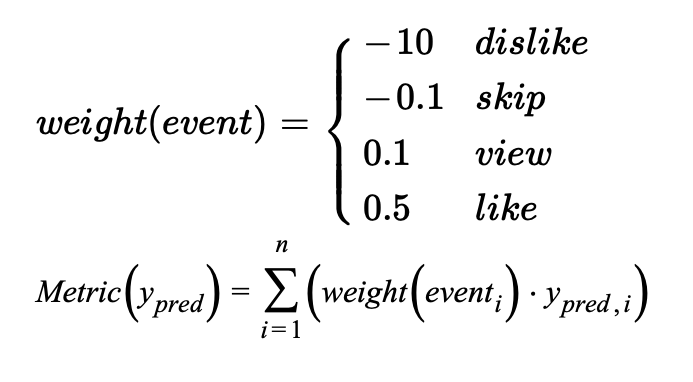

5. Разбиение на **public/privat** тестовой выборки: **63% / 37%** соответственно;

6. Приём работ закончится **12 октября в 23:59**.

7. В одиночку или в составе команды **до четрёх человек** обучите модель, чтобы спрогнозировать реакцию зрителя на истории. 

8. В архиве ниже находятся **CSV-таблицы и файл**, который поможет расшифровать названия колонок.



In [2]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from ipywidgets import interact, IntSlider, fixed, FloatSlider

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Данные customer_train.csv и customer_test.csv
- customer_id	Идентификатор клиента
- product_X	Статус продукта. OPN - открыт, но не утилизирован. UTL - утилизирован. CLS - закрыт
- gender_cd	Пол. M - мужской. F - женский
- age	Возраст в годах
- marital_status_cd	Семейный статус:
  * MAR	Женат/замужем
  * CIV	Гражданский брак
  * DLW	Не проживает с супругом(ой)a
  * UNM	Холост/не замужем
  * DIV	Разведен (а)
  * WID	Вдовец, вдова

- children_cnt	Количество детей в штуках
- first_session_dttm	Дата и время первой сессии в приложении или личном кабинете на сайте
- job_position_cd	Категория занимаемой должности. См. словарь соответствия
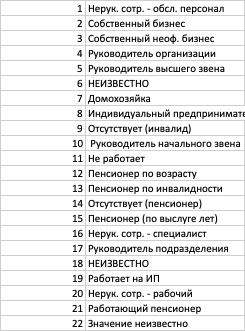
- job_title	Занимаемая должность

In [3]:
df_customer_train = pd.read_csv('customer_train.csv')
df_customer_test = pd.read_csv('customer_test.csv')

In [4]:
df_customer_train.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,894436,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,30.0,MAR,0.0,2018-03-20 09:10:16,1,Неруководящий сотрудник - обсл. Персонал
1,524526,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,20.0,UNM,0.0,2017-03-29 20:38:45,16,NaN
2,498134,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,25.0,UNM,0.0,2018-03-12 11:25:06,22,NaN
3,278941,NaN,NaN,UTL,CLS,NaN,UTL,UTL,M,25.0,NaN,NaN,2016-02-21 18:47:51,16,Неруководящий сотрудник - специалист
4,877312,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,40.0,MAR,0.0,2018-03-07 11:17:02,22,NaN


In [5]:
df_customer_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
customer_id           50000 non-null int64
product_0             1599 non-null object
product_1             23725 non-null object
product_2             4391 non-null object
product_3             6813 non-null object
product_4             2182 non-null object
product_5             33426 non-null object
product_6             2354 non-null object
gender_cd             49637 non-null object
age                   49690 non-null float64
marital_status_cd     31207 non-null object
children_cnt          44729 non-null float64
first_session_dttm    49997 non-null object
job_position_cd       50000 non-null int64
job_title             26497 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 5.7+ MB


In [6]:
df_customer_train.isna().sum()

customer_id               0
product_0             48401
product_1             26275
product_2             45609
product_3             43187
product_4             47818
product_5             16574
product_6             47646
gender_cd               363
age                     310
marital_status_cd     18793
children_cnt           5271
first_session_dttm        3
job_position_cd           0
job_title             23503
dtype: int64

In [7]:
df_customer_train.describe()

,customer_id,age,children_cnt,job_position_cd
count,5.000000e+04,49690.000000,44729.000000,50000.000000
mean,4.872847e+05,33.902093,0.243936,16.363140
std,2.818928e+05,9.642922,0.604332,6.422185
min,1.500000e+01,15.000000,0.000000,1.000000
25%,2.428222e+05,25.000000,0.000000,16.000000
50%,4.867070e+05,30.000000,0.000000,17.000000
75%,7.310072e+05,40.000000,0.000000,22.000000
max,1.103495e+06,85.000000,6.000000,22.000000


In [8]:
df_customer_train.shape, df_customer_test.shape

((50000, 15), (54245, 15))

## Данные stories_reaction_train.csv, stories_reaction_test.csv и sample_submit.csv

### stories_reaction_train	
- customer_id	Идентификатор клиента
- story_id	Идентификатор истории
- event_dttm	Дата действия
- **-> TARGET <-** event	Тип действия:
  * like - лайк или сохранение
  * view - глубокий просмотр (более 10 секунд)
  * skip - пролистанная - история (менее 5 секунд)
  * dislike - дизлайк 

### stories_reaction_test	
- customer_id	Идентификатор клиента
- story_id	Идентификатор истории
- event_dttm	Дата действия
- answer_id	Идентификатор ответа, который надо передать в посчитанном файле sample_submit.csv

In [9]:
df_stories_reaction_train = pd.read_csv('stories_reaction_train.csv')
#df_stories_reaction_test = pd.read_csv('stories_reaction_test.csv')

In [10]:
df_stories_reaction_train.head()

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip
3,15,379,2018-05-23 05:41:43,skip
4,15,544,2018-07-25 02:16:29,view


In [11]:
df_stories_reaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473141 entries, 0 to 473140
Data columns (total 4 columns):
customer_id    473141 non-null int64
story_id       473141 non-null int64
event_dttm     473141 non-null object
event          473141 non-null object
dtypes: int64(2), object(2)
memory usage: 14.4+ MB


In [14]:
df_stories_reaction_train.shape, \
#df_stories_reaction_test.shape

((473141, 4),)

## Баланс классов

Баланс классов: 
event
dislike      6575
like        56687
skip       167567
view       242312
Name: event, dtype: int64


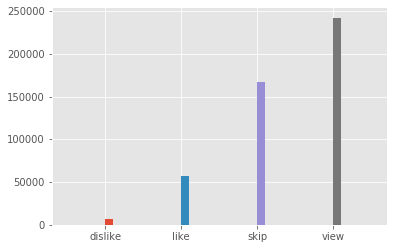

In [15]:
print("Баланс классов: \n{}".format(df_stories_reaction_train.groupby('event')['event'].count()))

df_stories_reaction_train.groupby('event')['event'].hist();

## Пример файла с решением

In [16]:
df_sample_submit = pd.read_csv('sample_submit.csv')
df_sample_submit.head()

,answer_id,score
0,0,0.85
1,1,0.53
2,2,-0.89
3,3,0.54
4,4,0.34


In [17]:
df_sample_submit = 0

## Данные stories_description.csv
	
- story_id	Идентификатор истории
- story_json	Исчерпывающее описание истории в формате json

In [18]:
df_stories_description = pd.read_csv('stories_description.csv')

In [19]:
df_stories_description.head()

,story_id,story_json
0,127,"{""guid"":""770a5bae-0e3f-4a6b-b924-bd87bd51a038""..."
1,254,"{""guid"":""64f4c9ef-647b-4e04-b4d4-02297e939388""..."
2,865,"{""guid"":""3482206b-d223-4aec-92ba-0150055cd68a""..."
3,1491,"{""guid"":""5f4a9215-01de-4777-b70f-a18899db8f1c""..."
4,598,"{""guid"":""ed8754bd-67be-4fa1-9289-5508d96f1fa4""..."


In [20]:
# with open('story.json', 'w') as outfile:
#     json.dump(df_stories_description.iloc[2, 1], outfile)

In [21]:
df_stories_description = 0

## Данные transactions.csv

- customer_id	Идентификатор клиента
- transaction_month	Месяц транзакции
- transaction_day	День транзакции
- transaction_amt	Сумма транзакции в рублях
- merchant_id	Идентификатор магазина, в котором была совершена транзакция
- merchant_mcc	MCC-категория магазина


In [22]:
df_transactions = pd.read_csv('transactions.csv')

In [23]:
df_transactions.head()

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
0,855115,7,3,1500,4554547,5411
1,997036,6,6,0,1657528,5411
2,398237,5,24,2500,26375569,5813
3,997036,6,2,0,16304402,5411
4,291636,7,25,0,1259505,5411


In [24]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3951115 entries, 0 to 3951114
Data columns (total 6 columns):
customer_id          int64
transaction_month    int64
transaction_day      int64
transaction_amt      int64
merchant_id          int64
merchant_mcc         int64
dtypes: int64(6)
memory usage: 180.9 MB


In [25]:
df_transactions.isna().sum()

customer_id          0
transaction_month    0
transaction_day      0
transaction_amt      0
merchant_id          0
merchant_mcc         0
dtype: int64

In [26]:
df_transactions = df_transactions[df_transactions['customer_id'] <= 100000] # для экономии памяти

## Посмотрим на то, как работают методы снижения размерности

In [150]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

In [151]:
def plot_PCA(pca_coord, y):
    fig = plt.figure(1, figsize=(8, 6))

    pca=PCA(n_components=2) # Просим PCA вернуть 2 коодинаты. По умолчанию вернет столько же, сколько подадим на вход.
    show_reduced = pca.fit_transform(pca_coord)

    fig, ax = plt.subplots() # Рисуем двумерную картинку.
    ax.scatter(show_reduced[:, 0], show_reduced[:, 1], c=y, 
               cmap=plt.cm.autumn, edgecolor='b', s=40)
    plt.show()
    print(pca.components_) # вектора, которыми поворачивались признаки

In [ ]:
plot_PCA(df_customer_train.values)

In [156]:
from sklearn.manifold import MDS

In [159]:
from sklearn.manifold import TSNE

In [161]:
import umap

In [ ]:
X = df_transactions.values[:3000] # возьмем 3000, иначе не хватает памяти
y = df_transactions['transaction_month'].values[:3000]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

mds=MDS(random_state=0)
X_mds = pca.fit_transform(X)

tsne=TSNE()
X_tsne = tsne.fit_transform(X)

umap_ = umap.UMAP()
X_umap = umap_.fit_transform(X)

In [ ]:
palette = sns.color_palette("bright", len(pd.unique(y))) 

plt.figure(figsize=(10, 10))
sns.scatterplot(X_pca[:,0],X_pca[:,1], palette=palette, hue=y)

In [ ]:
palette = sns.color_palette("bright", len(pd.unique(y))) 

plt.figure(figsize=(10, 10))
sns.scatterplot(X_mds[:,0],X_mds[:,1], palette=palette, hue=y)

In [ ]:
palette = sns.color_palette("bright", len(pd.unique(y))) 

plt.figure(figsize=(10, 10))
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], palette=palette, hue=y)

In [ ]:
palette = sns.color_palette("bright", len(pd.unique(y))) 

plt.figure(figsize=(10, 10))
sns.scatterplot(X_umap[:,0],X_umap[:,1], palette=palette, hue=y)

## Объединим таблицы с данными

In [61]:
df_customer_train.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,894436,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,30.0,MAR,0.0,2018-03-20 09:10:16,1,Неруководящий сотрудник - обсл. Персонал
1,524526,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,20.0,UNM,0.0,2017-03-29 20:38:45,16,NaN
2,498134,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,25.0,UNM,0.0,2018-03-12 11:25:06,22,NaN
3,278941,NaN,NaN,UTL,CLS,NaN,UTL,UTL,M,25.0,NaN,NaN,2016-02-21 18:47:51,16,Неруководящий сотрудник - специалист
4,877312,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,40.0,MAR,0.0,2018-03-07 11:17:02,22,NaN


In [62]:
df_customer_train[df_customer_train['customer_id']==36823]

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
330,36823,NaN,UTL,NaN,NaN,NaN,UTL,NaN,M,25.0,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор


In [63]:
df_customer_train[df_customer_train['customer_id']==36823].shape

(1, 15)

In [64]:
df_transactions.head()

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
28,36823,7,22,0,2954794,5411
29,36823,6,10,0,2954794,5411
30,36823,7,29,0,28404807,5947
43,68889,7,5,2500,957692,5992
45,10845,7,12,500,100276903,5947


In [65]:
df_transactions[df_transactions['customer_id']==36823].head()

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
28,36823,7,22,0,2954794,5411
29,36823,6,10,0,2954794,5411
30,36823,7,29,0,28404807,5947
725,36823,5,31,500,7143475,5411
726,36823,7,31,500,48354238,5947


In [66]:
df_transactions[df_transactions['customer_id']==36823].shape

(231, 6)

In [67]:
df_cust_and_trans = pd.merge(df_customer_train, df_transactions, on='customer_id')
df_cust_and_trans.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
0,66158,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,30.0,MAR,0.0,2013-03-17 08:26:13,22,СПЕЦИАЛИСТ,7,13,500,27823336,5411
1,66158,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,30.0,MAR,0.0,2013-03-17 08:26:13,22,СПЕЦИАЛИСТ,6,11,500,27823336,5411
2,66158,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,30.0,MAR,0.0,2013-03-17 08:26:13,22,СПЕЦИАЛИСТ,6,10,0,45522203,5331
3,66158,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,30.0,MAR,0.0,2013-03-17 08:26:13,22,СПЕЦИАЛИСТ,6,8,2000,27823336,5411
4,66158,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,30.0,MAR,0.0,2013-03-17 08:26:13,22,СПЕЦИАЛИСТ,6,17,500,27823336,5411


In [68]:
df_cust_and_trans[df_cust_and_trans['customer_id']==36823].head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
3250,36823,NaN,UTL,NaN,NaN,NaN,UTL,NaN,M,25.0,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,22,0,2954794,5411
3251,36823,NaN,UTL,NaN,NaN,NaN,UTL,NaN,M,25.0,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,6,10,0,2954794,5411
3252,36823,NaN,UTL,NaN,NaN,NaN,UTL,NaN,M,25.0,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,29,0,28404807,5947
3253,36823,NaN,UTL,NaN,NaN,NaN,UTL,NaN,M,25.0,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,5,31,500,7143475,5411
3254,36823,NaN,UTL,NaN,NaN,NaN,UTL,NaN,M,25.0,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,31,500,48354238,5947


In [69]:
df_cust_and_trans[df_cust_and_trans['customer_id']==36823].shape

(231, 20)

In [70]:
df_stories_reaction_train.head()

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip
3,15,379,2018-05-23 05:41:43,skip
4,15,544,2018-07-25 02:16:29,view


In [71]:
df_stories_reaction_train[df_stories_reaction_train['customer_id']==36823].head()

,customer_id,story_id,event_dttm,event
15554,36823,1101,2018-07-01 08:34:45,skip
15555,36823,1224,2018-07-14 15:43:13,view


In [72]:
df_stories_reaction_train[df_stories_reaction_train['customer_id']==36823].shape

(2, 4)

In [73]:
df_cust_trans_reactions = pd.merge(df_stories_reaction_train, df_cust_and_trans, on='customer_id')

In [74]:
df_cust_trans_reactions.head()

,customer_id,story_id,event_dttm,event,product_0,product_1,product_2,product_3,product_4,product_5,...,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
0,15,138,2018-07-24 15:33:22,view,NaN,CLS,UTL,UTL,NaN,UTL,...,MAR,1.0,2012-06-06 09:57:21,17,НАЧАЛЬНИК ОТДЕЛА,6,5,2000,23120698,5921
1,15,138,2018-07-24 15:33:22,view,NaN,CLS,UTL,UTL,NaN,UTL,...,MAR,1.0,2012-06-06 09:57:21,17,НАЧАЛЬНИК ОТДЕЛА,6,29,269500,558297,7011
2,15,138,2018-07-24 15:33:22,view,NaN,CLS,UTL,UTL,NaN,UTL,...,MAR,1.0,2012-06-06 09:57:21,17,НАЧАЛЬНИК ОТДЕЛА,7,23,375000,97227486,3011
3,15,138,2018-07-24 15:33:22,view,NaN,CLS,UTL,UTL,NaN,UTL,...,MAR,1.0,2012-06-06 09:57:21,17,НАЧАЛЬНИК ОТДЕЛА,5,30,2500,23648912,5411
4,15,138,2018-07-24 15:33:22,view,NaN,CLS,UTL,UTL,NaN,UTL,...,MAR,1.0,2012-06-06 09:57:21,17,НАЧАЛЬНИК ОТДЕЛА,5,26,3500,23648912,5411


In [75]:
df_cust_trans_reactions[df_cust_trans_reactions['customer_id']==36823]

,customer_id,story_id,event_dttm,event,product_0,product_1,product_2,product_3,product_4,product_5,...,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
1756488,36823,1101,2018-07-01 08:34:45,skip,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,22,0,2954794,5411
1756489,36823,1101,2018-07-01 08:34:45,skip,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,6,10,0,2954794,5411
1756490,36823,1101,2018-07-01 08:34:45,skip,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,29,0,28404807,5947
1756491,36823,1101,2018-07-01 08:34:45,skip,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,5,31,500,7143475,5411
1756492,36823,1101,2018-07-01 08:34:45,skip,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,31,500,48354238,5947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756945,36823,1224,2018-07-14 15:43:13,view,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,19,0,77187702,4121
1756946,36823,1224,2018-07-14 15:43:13,view,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,6,28,0,11927248,4111
1756947,36823,1224,2018-07-14 15:43:13,view,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,6,9,500,102251864,4121
1756948,36823,1224,2018-07-14 15:43:13,view,NaN,UTL,NaN,NaN,NaN,UTL,...,UNM,0.0,2012-06-20 14:12:14,22,Генеральный директор,7,20,0,77187702,4121


In [76]:
df_cust_trans_reactions.dropna(inplace=True) # удаляем NA, т.к. дальше не хватит памяти
df_cust_trans_reactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 189429 to 190163
Data columns (total 23 columns):
customer_id           735 non-null int64
story_id              735 non-null int64
event_dttm            735 non-null object
event                 735 non-null object
product_0             735 non-null object
product_1             735 non-null object
product_2             735 non-null object
product_3             735 non-null object
product_4             735 non-null object
product_5             735 non-null object
product_6             735 non-null object
gender_cd             735 non-null object
age                   735 non-null float64
marital_status_cd     735 non-null object
children_cnt          735 non-null float64
first_session_dttm    735 non-null object
job_position_cd       735 non-null int64
job_title             735 non-null object
transaction_month     735 non-null int64
transaction_day       735 non-null int64
transaction_amt       735 non-null int64
merchant_

In [77]:
df_cust_trans_reactions.head()

,customer_id,story_id,event_dttm,event,product_0,product_1,product_2,product_3,product_4,product_5,...,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
189429,3298,379,2018-07-04 05:32:51,skip,UTL,CLS,UTL,CLS,CLS,UTL,...,UNM,0.0,2012-06-09 08:10:55,14,Пенсия по возрасту/стажу работы,7,8,6000,60708122,5813
189430,3298,379,2018-07-04 05:32:51,skip,UTL,CLS,UTL,CLS,CLS,UTL,...,UNM,0.0,2012-06-09 08:10:55,14,Пенсия по возрасту/стажу работы,7,3,6000,17587266,5945
189431,3298,379,2018-07-04 05:32:51,skip,UTL,CLS,UTL,CLS,CLS,UTL,...,UNM,0.0,2012-06-09 08:10:55,14,Пенсия по возрасту/стажу работы,6,22,2000,62267993,5542
189432,3298,379,2018-07-04 05:32:51,skip,UTL,CLS,UTL,CLS,CLS,UTL,...,UNM,0.0,2012-06-09 08:10:55,14,Пенсия по возрасту/стажу работы,7,2,3500,16072477,5812
189433,3298,379,2018-07-04 05:32:51,skip,UTL,CLS,UTL,CLS,CLS,UTL,...,UNM,0.0,2012-06-09 08:10:55,14,Пенсия по возрасту/стажу работы,6,14,500,18871351,4784


## Покластеризуем

In [78]:
from sklearn.cluster import DBSCAN

In [79]:
from sklearn.preprocessing import LabelEncoder

In [80]:
le = LabelEncoder().fit(df_cust_trans_reactions['event'])

In [81]:
df_cust_trans_reactions['event'] = le.transform(df_cust_trans_reactions['event'])

In [82]:
df_cust_trans_reactions['event']

189429    0
189430    0
189431    0
189432    0
189433    0
         ..
190159    0
190160    0
190161    0
190162    0
190163    0
Name: event, Length: 735, dtype: int64

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=5).fit(
        df_cust_trans_reactions[
            ['event', 
             'age',
             'children_cnt', 
             'job_position_cd', 
             'transaction_month',
             'transaction_day',
             'transaction_amt',
             'merchant_id',
             'merchant_mcc']])
    
df_cust_trans_reactions['labels'] = dbscan.labels_+1
    
plt.figure(figsize=(7,5))
plt.scatter(df_cust_trans_reactions.iloc[:,0], df_cust_trans_reactions.iloc[:,3], c=dbscan.labels_+1)
    
plt.show()

In [108]:
db = DBSCAN(eps=1, min_samples=2)
cl = db.fit_predict(df_cust_trans_reactions[['event', 
             'age',
             'children_cnt', 
             'job_position_cd', 
             'transaction_month',
             'transaction_day',
             'transaction_amt',
             'merchant_id',
             'merchant_mcc']])+1

In [109]:
import umap
um = umap.UMAP()
v2 = um.fit_transform(df_cust_trans_reactions[['event', 
             'age',
             'children_cnt', 
             'job_position_cd', 
             'transaction_month',
             'transaction_day',
             'transaction_amt',
             'merchant_id',
             'merchant_mcc']])

/home/jupyterhub/jupyterhub_venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 92 separate connected components using meta-embedding (experimental)
  n_components
/home/jupyterhub/jupyterhub_venv/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


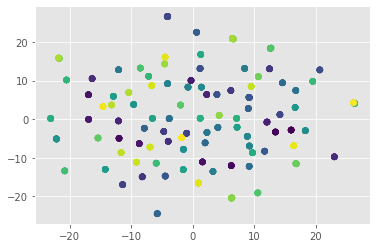

In [110]:
plt.scatter(x=v2[:,0], y=v2[:,1], c=cl+1)

In [ ]:
# продолжение следует....